# Transient object detection

## 1. Introduction

This notebook walks through how to develop a workflow for generating synthetic data and training a machine learning model to detect meteors from images.

This tutorial has been prepared by:
- [Andrew Rohl](http://computation.curtin.edu.au/about/steering-committee/director/)
- [Shiv Meka](http://computation.curtin.edu.au/about/computational-specialists/humanities/)
- [Kevin Chai](http://computation.curtin.edu.au/about/computational-specialists/health-sciences/)

from the [Curtin Institute for Computation](http://computation.curtin.edu.au) at Curtin University in Perth, Australia for the [7th International Conference on Smart Computing & Communications (ICSCC 2019)](http://icscc.online/) hosted at Curtin University in Miri, Sarawak, Malaysia on the 28-30 June 2019.

## 2. Project

### Background

The Curtin Institute for Computation was asked to develop a machine learning model to detect meteor trails (fireballs) by researchers from the [Curtin Institute for Radio Astronomy](http://astronomy.curtin.edu.au/) ([ICRAR](https://www.icrar.org/) - Curtin University node) from images of the night sky captured in the Australian desert by the [Desert Fireball Network](http://fireballsinthesky.com.au/). 

![Fireballs](assets/desert_fireball_network.png)

<div style="text-align:center;font-weight:bold">Figure: Desert Fireball Network camera locations</div>

The objective of the project is to find these meteors in optical images and to compare against the radio emissions recorded at the same time and location by the [Murchison Widefield Array](http://www.mwatelescope.org).

### Team

*Curtin Institute for Radio Astronomy (CIRA)*
* Paul Hancock
* Xiang Zhang
* Sean Mattingley
* Steven Tingay
* Randall Wayth

*Desert Fireball Network*
* Hadrien Devillepoix
* Phil Bland

*Curtin Institute for Computation*
* Shiv Meka
* Kevin Chai

## 3. Data preparation

### Dataset

The dataset is comprised of images taken during the Geminid meteor shower on the 14th of December 2015. Images were captured from a camera based at a station and a camera that was set up on the back of a truck (mobile) to capture images from multiple locations. The images were reviewed and annotated by astronomers to construct the dataset shown in Table 1.

<p style="text-align:center;font-weight:bold">Table 1: Dataset</p>

| Camera      | Images    | Meteors
|:------------|:----------|:--------|
| mobile      | 1,561     | 48      |
| station     | 1,330     | 24      |

The raw dataset contains RGB images with a resolution of 7360x4912 pixels and are ~6.3MB each. Meteors within these images were manually identified by astronomers within the project team. Examples of these meteors are shown below.

![Fireballs](assets/meteors.png)

<div style="text-align:center;font-weight:bold">Figure: Cropped images containing meteors in the dataset</div>

From preliminary experiments, we observed that meteors could be identified without colour and using lower resolution images. The benefit of compressing the images is that it reduces the computational overhead required and therefore allows us to train a meteor detection model faster. 

The raw images are transformed into grayscale and to a resolution of 1840x1228, resulting in ~240KB for each image. An example is shown below.

![Fireballs](assets/night_sky_example.jpg)

<div style="text-align:center;font-weight:bold">Figure: Transformed night sky image example</div>

This data preparation pipeline can performed using the Python Imaging Library (PIL / Pillow) module. An example is presented below.

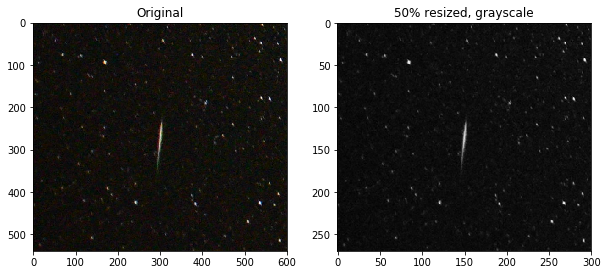

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

img = Image.open('assets/data_prep_example.jpg')

# Resize the new image to 50% of the original
img_new = img.resize((int(img.width * 0.5), int(img.height * 0.5)), Image.ANTIALIAS)

# Convert to grayscale
img_new = np.array(img_new.convert('L'))

# Plot the original and transformed image
fig = plt.figure(figsize=(10, 10))
# Original
ax1 = fig.add_subplot(121)
ax1.title.set_text('Original')
ax1.imshow(img);
# resized, grayscale
ax2 = fig.add_subplot(122)
ax2.title.set_text('50% resized, grayscale')
ax2.imshow(img_new, cmap='gray');

### Synthetic data

The dataset does not contain enough meteors to realistically train a robust and accurate machine learning model. Additionally, the research team simplified the objective of the project to identify transient objects (streaks) in the dataset. Transient objects can be meteors, satellites and planes. The detection of satellites and planes were useful for another project.

Therefore, we decided to experiment with generating a large synthetic dataset of transient objects for training our model. Through manual inspection, we identified 20 images of the night sky that contained no streaks. We use these as the background for our generated images.

From preliminary experiments, we create tiled images of 200 x 200 pixel resolution.

In [1]:
import h5py 
from PIL import Image,ImageDraw
import numpy as np

def fake_image(file_name="img.h5",batch_size=80):
    '''
    file_name: hdf file with images of night_sky and validation
    batch_size: images per step
    '''
    filter_w=200 #output image width
    filter_h=200 #output image height
    np.random.seed(0)
    def dist(A): #Computes distance between two points in px
        return(((A[0][0]-A[0][2])**2+(A[0][1]-A[0][3])**2)**0.5)

    count=0
    hdf=h5py.File("img.h5","r")
    bg_imgs=hdf["night_sky"][:]
    out_images=[] #list to store
    out_preds=[]
    while True:
        for i in range(batch_size):
            myrand=np.random.randint(bg_imgs.shape[0]) #Open files with random background and w/o meteorites
            im=Image.fromarray(bg_imgs[myrand]) #im stores images with random background
            width,height=im.size
            marker_x=np.random.randint(0,width-filter_w)
            marker_y=np.random.randint(0,width-filter_h)
            #crop a portion of the image
            im=im.crop((marker_x,marker_y,marker_x+filter_w,marker_y+filter_h))
            draw = ImageDraw.Draw(im)
            A=[(np.random.rand()*im.size[0], np.random.rand()*im.size[1],
                np.random.rand()*im.size[0], np.random.rand()*im.size[1])]
            myrand=str(myrand)
            flag_present=False
            if (np.random.rand()>0.5): #Statistically, only half the samples would have meteorites
                if ((dist(A)>30) and (dist(A)<300)): #The lines shouldn't be too short or too long
                    color_rnd=np.random.uniform(0.8,1.0)  #Brightness should be over certain threshold, lower the brightness -> harder to train, more resilient
                    width_rand=np.random.choice([1,2])
                    draw.line([A[0][0],A[0][1],A[0][2],A[0][3]], fill=int(color_rnd*250),width=width_rand)
                    flag_present=True
                    del draw
            out_images.append(np.array(im).reshape([filter_w,filter_h,1]))
            out_preds.append(flag_present*1)
        yield np.array(out_images),np.array(out_preds)

### Machine learning
The dataset does not contain enough meteors to develop a robust and accurate machine learning model. Therefore, we have

*TODO:* 



In [2]:
from keras.layers import Input,Conv2D,MaxPool2D,Dense,BatchNormalization,Flatten
from keras.models import Model
import numpy as np

#Basic hello world CNN
inp=Input(shape=(200,200,1))
Activation='relu'
out=[]
#3 layers of CNN-MaxPool cascades
for i in range(3):
    out=Conv2D(8+(i*2),3,activation=Activation)((out,inp)[i==0])
    out=MaxPool2D(2)(out)
    out=BatchNormalization()(out)
out=Flatten()(out)
#FF dense stack
for i in range(5):
    out=Dense(5)(out)
out=Dense(1,activation='sigmoid')(out)
mod=Model(inp,out)
mod.compile(optimizer='adagrad',loss='binary_crossentropy')

Using TensorFlow backend.


In [ ]:
mod.fit_generator(fake_image(),steps_per_epoch=10,epochs=2)

### Download data

In [ ]:
#Download and uncompress the dataset. 
#Does nothing if the file already exists
Download("https://cloudstor.aarnet.edu.au/plus/s/EubVHMQ1lq7zOfD/download","workshop.tar.gz")

In [ ]:
#Get a sense of how the directory structure looks like
!tree 
#For Windows, please use !tree /F /A